<a href="https://colab.research.google.com/github/dilne/Fixing-OOM-in-TensorFlow/blob/main/NotebookAndGuide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Intro
OOM errors are the worst! You've got an idea for the coolest AI system, you collect the data, you process the data, you define the architecture, you go to train and you're met with an out of memory error...

Fear no more! If you have 10,000 images, just create ten new datasets comprising data from the original dataset. Train your model with the first dataset, save the model, wipe the model from memory, load the model, continue training with the second dataset, and repeat!

The following are demonstrated within this notebook:
- A dataset of 10,000 greyscale images is loaded. This is done by repeatedly loading a single 512 x 512 greyscale image. If you used 10,000 greyscale images with 512 x 512 resolution and the model in this notebook, training should work up to approximately 12 GB VRAM, working inside Google Colab.
- The dataset is split into train and test data
- The train dataset is split into segments
- The model is defined
- The model is complied
- The model is trained in batches

This notebook will work in Google Colab with the GPU enabled (Runtime > Change runtime type > Hardware Accelerator > GPU), and we'll prove this throughout at the top of each text cell with the stats after running the previous cells:

***
Sys. RAM: 1.2/12.7 GB, GPU RAM: 0/15 GB, Disk: 25.2/78.2GB
***

In [1]:
import os
import gc
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import models, layers
import tensorflow as tf
from tensorflow import keras

***
Sys. RAM: 1.4/12.7 GB, GPU RAM: 0/15 GB, Disk: 25.2/78.2GB
***

This is used to "only grow the memory usage as is needed by the process": https://www.tensorflow.org/guide/gpu


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

1 Physical GPUs, 1 Logical GPUs
GPU is available


***
Sys. RAM: 1.5/12.7 GB, GPU RAM: 0.3/15 GB, Disk: 25.2/78.2GB
***

### Set Variables

In [14]:
width = int(512)
height = int(512)
dims = (width, height)
lower = 0
upper = 1000
data_info = False
graph_info = False

global num_epochs
num_epochs = 2
runs = 5

### Load Data
The data in this GitHub Repository is only one image. We will fabricate a dataset of 5,000 images by loading it 10,000 times. To do this, we simply use the following line:
```
for i in range(5000):
```
For your own dataset, you can simply remove this line.

In [ ]:
X = []
y = []

data_dir = "/content/"
for i in range(5000):  # remove this line in real use case
  for fname in sorted(os.listdir(data_dir)):
    if fname.endswith(".png") and not fname.startswith("."):
      path = os.path.join(data_dir, fname)
      feature = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      X.append((feature/255.).astype(np.float32))
      y.append(np.int8(0))

***
Sys. RAM: 11.8/12.7 GB, GPU RAM: 0.3/15 GB, Disk: 25.2/78.2GB
***

In [ ]:
X = np.array(X, copy=True)
y = np.array(y, copy=True)

In [ ]:
np.save("Data\X.npy", X)
np.save("Data\y.npy", y)

In [ ]:
X = np.load("Data\X.npy")
y = np.load("Data\y.npy")

In [ ]:
print("X:")
print("Samples: {}, Type: {}, Shape: {}, Min: {}, Max: {}".format(len(X), X.dtype, X[0].shape, X.min(), X.max()))
print()
print("Y:")
print("Samples: {}, Type: {}".format(len(y), y.dtype))
print()
print(len(X))
print(len(y))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print('X_train: ', len(X_train))
print('y_train: ', len(y_train))
print('X_test:  ', len(X_test))
print('y_test:  ', len(y_test))

In [ ]:
X_train_split = np.array_split(X_train, 10)
y_train_split = np.array_split(y_train, 10)
print(f"Length: {len(X_train_split)}")
print(f"Length of tenth: {len(X_train_split[0])}")

### Remove Unnecessary Variables

In [ ]:
del X
del y
del X_train
del y_train
gc.collect()

## Functions

### Preprocess Data Function

In [13]:
def loadData(lower, upper, data_info):
  X = []
  y = []

  cnt = 0
  data_dir = "/content/drive/MyDrive/GitHub/Fixing-OOM-in-TensorFlow/DummyData"
  limit = len(os.listdir(data_dir))
  diff = upper - lower
  extra = upper - limit
  print(f"Processing data chunk {lower} to {extra if upper > limit else upper} of {len(sorted(os.listdir(data_dir)))}...")

  if upper > limit:
    for fname in sorted(os.listdir(data_dir))[lower:limit]:
      if fname.endswith(".png") and not fname.startswith("."):
        path = os.path.join(data_dir, fname)
        feature = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        X.append((feature/255.).astype(np.float32))
        y.append(np.int8(0))

    lower = 0
    upper = extra
    for fname in sorted(os.listdir(data_dir))[lower:upper]:
      if fname.endswith(".png") and not fname.startswith("."):
        path = os.path.join(data_dir, fname)
        feature = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        X.append((feature/255.).astype(np.float32))
        y.append(np.int8(0))

    lower = lower + extra
    upper = upper+diff
  else:
    for fname in sorted(os.listdir(data_dir))[lower:upper]:
      if fname.endswith(".png") and not fname.startswith("."):
        path = os.path.join(data_dir, fname)
        feature = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        X.append((feature/255.).astype(np.float32))
        y.append(np.int8(0))

    lower = lower+diff
    upper = upper+diff

  X = np.array(X, copy=True)
  y = np.array(y, copy=True)
  if data_info == True:
    print("X:")
    print(f"Samples: {len(X)}, Type: {X.dtype}, Shape: {X[0].shape}, Min: {X.min()}, Max: {X.max()}\n")
    print("Y:")
    print(f"Samples: {len(y)}, Type: {y.dtype}\n")
    print(len(X))
    print(len(y))

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
  if data_info == True:
    print(f"X_train: {len(X_train)}")
    print(f"y_train: {len(y_train)}")
    print(f"X_test:  {len(X_test)}")
    print(f"y_test:  {len(y_test)}")

  X_train_split = np.array_split(X_train, runs)
  y_train_split = np.array_split(y_train, runs)
  if data_info == True:
    print(f"Length: {len(X_train_split)}")
    print(f"Length of tenth: {len(X_train_split[0])}")

  del X
  del y
  del X_train
  del y_train
  gc.collect()

  print(f"Data processed successfully\n")

  return lower, upper, X_test, y_test, X_train_split, y_train_split

### Define Model Function

In [5]:
def define_model():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(width, height, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))

  return(model)

### Compile Model Function

In [6]:
def compile_model(model):
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    
  return(model)

### Display Accuracy Function

In [7]:
  def display_accuracy(results):  
    x = np.empty((0))
    for i in range(num_epochs):
        x = np.append(x, i+1)
    fig, axis = plt.subplots(1, 2, figsize=(20, 5))
    axis[0].plot(x, results.history["loss"], color='r', label = 'train loss')
    axis[0].plot(x, results.history["val_loss"], color='b', label = 'val loss')
    axis[0].set_title('Loss Comparison')
    axis[0].legend()
    axis[0].set_ylim([0,0.1e-0])
    axis[1].plot(x, results.history["accuracy"], color='r', label = 'train accuracy')
    axis[1].plot(x, results.history["val_accuracy"], color='b', label = 'val accuracy')
    axis[1].set_title('Accuracy Comparison')
    axis[1].legend()
    axis[1].set_ylim([0.9, 1])
    plt.show()

### Define Callback
Here we use a callback function to save the model at the end of the last epoch within each run. This way, the model weights are saved so they can be loaded again after garbage collection and training can be continued on the new data.

We have an if statement that checks if we're on the final epoch, if it is, the model is saved to a file path containing "final", in all other instances, the file path contains "temp".

In [8]:
class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, i):
        self.i = i
    
    def on_epoch_end(self, epoch, logs={}):
      if epoch == num_epochs-1:
        global save_path_h5
        if i == runs - 1: folder = "final"
        else: folder = "temp"
        save_path_h5 = f"\content\Model Saves\{folder}\h5\model_save.h5"
        model.save(save_path_h5)

        # you might want to save as .pb too,
        # but you can't load a pb to continue training
        # so it's only useful for a final model save
        # global save_path_pb
        # save_path_pb = f"\Model Saves\final\pb\model_save"
        # tf.saved_model.save(model, save_path_pb)

## Train Model

In [15]:
lower, upper, X_test, y_test, X_train_split, y_train_split = loadData(lower, upper, data_info)
results_list = []
model = define_model()
model = compile_model(model)

for i in range(runs):
    if i != 0:
        print()
        del model
        tf.keras.backend.clear_session()
        gc.collect()
        model = tf.keras.models.load_model(save_path_h5)
        lower, upper, X_test, y_test, X_train_split, y_train_split = loadData(lower, upper, data_info)
        model = compile_model(model)
    print(f"Run {i+1}/{runs}")


    results = model.fit(X_train_split[i], y_train_split[i], batch_size=2, epochs=num_epochs, 
                        validation_data=(X_test, y_test), shuffle=True, verbose=1,
                        callbacks=[SaveModelCallback(i)])
    results_list.append(results)

    if graph_info == True:
      display_accuracy(results)

Processing data chunk 0 to 1000 of 3010...
Data processed successfully

Run 1/5
Epoch 1/2
 4/75 [>.............................] - ETA: 1s - loss: 0.1783 - accuracy: 0.7500     

75/75 [==============================] - 2s 23ms/step - loss: 0.0095 - accuracy: 0.9867 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
75/75 [==============================] - 3s 36ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Processing data chunk 1000 to 2000 of 3010...
Data processed successfully

Run 2/5
Epoch 1/2
 5/75 [=>............................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 1.0000 

75/75 [==============================] - 2s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
75/75 [==============================] - 3s 38ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Processing data chunk 2000 to 3000 of 3010...
Data processed successfully

Run 3/5
Epoch 1/2
 4/75 [>.............................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 1.0000 

75/75 [==============================] - 2s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
75/75 [==============================] - 3s 38ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Processing data chunk 3000 to 990 of 3010...
Data processed successfully

Run 4/5
Epoch 1/2
 4/75 [>.............................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 1.0000 

75/75 [==============================] - 2s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
75/75 [==============================] - 3s 35ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Processing data chunk 990 to 1990 of 3010...
Data processed successfully

Run 5/5
Epoch 1/2
 4/75 [>.............................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 1.0000 

75/75 [==============================] - 2s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
75/75 [==============================] - 2s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


### Accuracy over all epochs

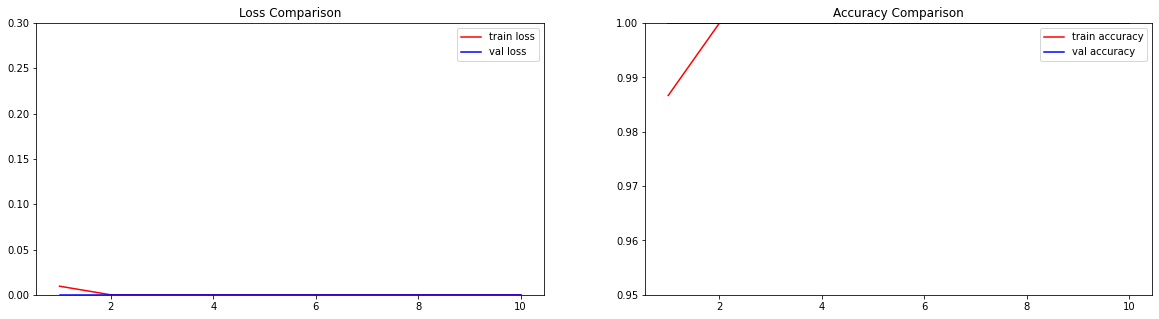

In [16]:
merged_results = pd.concat([pd.DataFrame(result.history) for result in results_list], ignore_index=True)

x = np.arange(1,len(merged_results)+1)
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(x, merged_results["loss"], color='r', label = 'train loss')
axis[0].plot(x, merged_results["val_loss"], color='b', label = 'val loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[0].set_ylim([0,0.3])
axis[1].plot(x, merged_results["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(x, merged_results["val_accuracy"], color='b', label = 'val accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
axis[1].set_ylim([0.95, 1])
plt.show()